In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine

In [2]:
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name='class')

In [3]:
X = X.fillna(X.mean())

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


In [5]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_scaled, y)

GradientBoostingClassifier(random_state=42)

In [6]:
selector = SelectFromModel(gbc, threshold='median')
selector.fit(X_scaled, y)

SelectFromModel(estimator=GradientBoostingClassifier(random_state=42),
                threshold='median')

In [7]:
selected_features = X_scaled.columns[selector.get_support()].tolist()
print(f"Selected features: {selected_features}")

Selected features: ['alcohol', 'malic_acid', 'magnesium', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline']


In [8]:
X_selected = X_scaled[selected_features]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [10]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [11]:
gbc = GradientBoostingClassifier(random_state=42)

In [12]:
# Perform grid search
grid_search = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

In [13]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [14]:
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [15]:
y_pred = best_model.predict(X_test)

In [16]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=wine.target_names))

Accuracy: 0.8889

Classification Report:
              precision    recall  f1-score   support

     class_0       0.93      1.00      0.97        14
     class_1       0.81      0.93      0.87        14
     class_2       1.00      0.62      0.77         8

    accuracy                           0.89        36
   macro avg       0.92      0.85      0.87        36
weighted avg       0.90      0.89      0.88        36



In [17]:
# Cross-validation
cv_scores = cross_val_score(best_model, X_selected, y, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy scores: {cv_scores}")
print(f"Average CV Accuracy score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-validation Accuracy scores: [0.97222222 0.91666667 0.88888889 0.97142857 0.97142857]
Average CV Accuracy score: 0.9441 (+/- 0.0698)


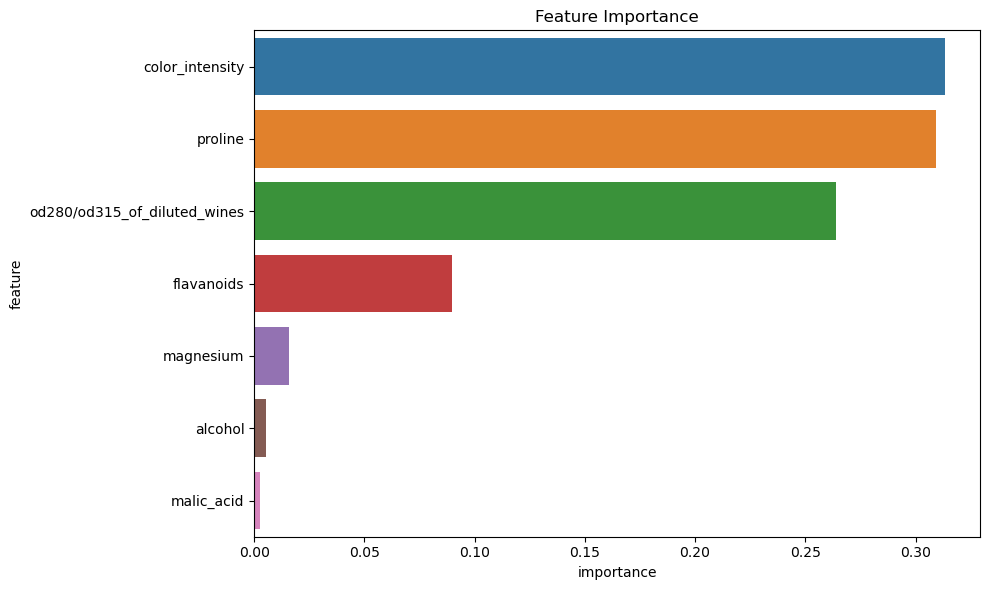

In [18]:
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()